In [6]:
import cv2
from matplotlib import pyplot as plt
import math
import numpy as np

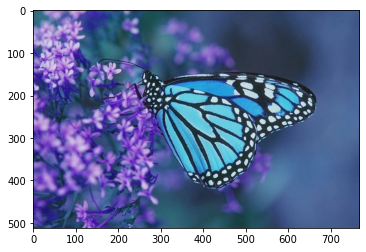

In [7]:
## if __name__ == “main”
# PATCH - SIZE : 7*7
# Declaring parameters for the retargeting
minImgSize = 30;                # lowest scale resolution size for min(w, h)
numScales = 10;                 # number of scales (distributed logarithmically)


## Preparing data for the retargeting
pathname = 'img/ours_10_aaa.jpg'
dx, dy = 1, 0.6
org_image = cv2.imread(pathname)
plt.imshow(org_image)
h, w, _ = org_image.shape
resized_image = cv2.resize(org_image, None, fx = dx, fy = dy)

47 12


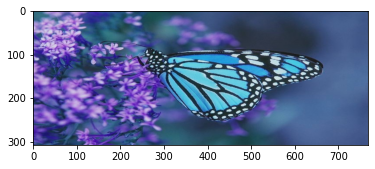

In [8]:
plt.imshow(resized_image)
image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2LAB)
iters = 5
patch_R, patch_C= 7, 7
## retargeting at havlved images
target_w= 30;

down_w = 47;
down_h = math.ceil(dy * h * target_w / (dx * w))

down_source = (np.zeros([down_h, down_w, 3])).astype(np.uint8)
print(down_w, down_h)
for i in range(down_h):
    for j in range(down_w):
        down_R = math.ceil(i * h / down_h)
        down_C = math.ceil(j * w / down_w)
        down_source[i][j][0] = org_image[down_R][down_C][0]
        down_source[i][j][1] = org_image[down_R][down_C][1]
        down_source[i][j][2] = org_image[down_R][down_C][2]
#plt.imshow(down_source)

In [ ]:


targetSize = outSizeFactor[0] .* [h, w];
#imageLab = rgb2lab(image); % Convert the source and target Images
#imageLab = double(imageLab)/255;
#imageLab = double(image)/255;


# Gradual Scaling - iteratively icrease the relative resizing scale between the input and
# the output (working in the coarse level).
## STEP 1 - do the retargeting at the coarsest level
S = imresize(imageLab,35/194);
res = S;
for i in range(1, 2, 17)""
    res = imresize(res,[35 47-i]);
    [res, ~, ~] = search(S , res, 6 ,1, i, 'C:\Users\User\Desktop\FinalProject', 'Patch');

## STEP 2 - do resolution refinment 
# (upsample for numScales times to get the desired resolution)
for i in range(numScales):
    res = imresize(res,[35+15*i,30+13*i]);
    S = imresize(imageLab,[35+15*i,30+13*i]);
    [res, ~, ~] = search(S, res, 4, 2, i, 'C:\Users\User\Desktop\FinalProject', 'Patch');

## STEP 3 - do final scale iterations
# (refine the result at the last scale)
res = imresize(res,[194 169]);
[res, ann, bnn] = search(imageLab, res, 4, 3, i, 'C:\Users\User\Desktop\FinalProject', 'Patch');

In [16]:
import numpy as np
from PIL import Image
import time
from tqdm.notebook import tqdm

def cal_distance(a, b, A_padding, B, p_size):
    p = p_size // 2
    patch_a = A_padding[a[0]:a[0]+p_size, a[1]:a[1]+p_size, :]
    patch_b = B[b[0]-p:b[0]+p+1, b[1]-p:b[1]+p+1, :]
    temp = patch_b - patch_a
    num = np.sum(1 - np.int32(np.isnan(temp)))
    dist = np.sum(np.square(np.nan_to_num(temp))) / num
    return dist

def reconstruction(f, A, B):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    temp = np.zeros_like(A)
    for i in tqdm(range(A_h)):
        for j in range(A_w):
            temp[i, j, :] = B[f[i, j][0], f[i, j][1], :]
    Image.fromarray(temp).show()


def initialization(A, B, p_size):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    B_h = np.size(B, 0)
    B_w = np.size(B, 1)
    p = p_size // 2
    random_B_r = np.random.randint(p, B_h-p, [A_h, A_w])
    random_B_c = np.random.randint(p, B_w-p, [A_h, A_w])
    A_padding = np.ones([A_h+p*2, A_w+p*2, 3]) * np.nan
    A_padding[p:A_h+p, p:A_w+p, :] = A
    f = np.zeros([A_h, A_w], dtype=object)
    dist = np.zeros([A_h, A_w])
    for i in range(A_h):
        for j in range(A_w):
            a = np.array([i, j])
            b = np.array([random_B_r[i, j], random_B_c[i, j]], dtype=np.int32)
            f[i, j] = b
            dist[i, j] = cal_distance(a, b, A_padding, B, p_size)
    return f, dist, A_padding

def propagation(f, a, dist, A_padding, B, p_size, is_odd):
    A_h = np.size(A_padding, 0) - p_size + 1
    A_w = np.size(A_padding, 1) - p_size + 1
    x = a[0]
    y = a[1]
    if is_odd:
        d_left = dist[max(x-1, 0), y]
        d_up = dist[x, max(y-1, 0)]
        d_current = dist[x, y]
        idx = np.argmin(np.array([d_current, d_left, d_up]))
        if idx == 1:
            f[x, y] = f[max(x - 1, 0), y]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)
        if idx == 2:
            f[x, y] = f[x, max(y - 1, 0)]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)
    else:
        d_right = dist[min(x + 1, A_h-1), y]
        d_down = dist[x, min(y + 1, A_w-1)]
        d_current = dist[x, y]
        idx = np.argmin(np.array([d_current, d_right, d_down]))
        if idx == 1:
            f[x, y] = f[min(x + 1, A_h-1), y]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)
        if idx == 2:
            f[x, y] = f[x, min(y + 1, A_w-1)]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)

def random_search(f, a, dist, A_padding, B, p_size, alpha=0.5):
    x = a[0]
    y = a[1]
    B_h = np.size(B, 0)
    B_w = np.size(B, 1)
    p = p_size // 2
    i = 4
    search_h = B_h * alpha ** i
    search_w = B_w * alpha ** i
    b_x = f[x, y][0]
    b_y = f[x, y][1]
    while search_h > 1 and search_w > 1:
        search_min_r = max(b_x - search_h, p)
        search_max_r = min(b_x + search_h, B_h-p)
        random_b_x = np.random.randint(search_min_r, search_max_r)
        search_min_c = max(b_y - search_w, p)
        search_max_c = min(b_y + search_w, B_w - p)
        random_b_y = np.random.randint(search_min_c, search_max_c)
        search_h = B_h * alpha ** i
        search_w = B_w * alpha ** i
        b = np.array([random_b_x, random_b_y])
        d = cal_distance(a, b, A_padding, B, p_size)
        if d < dist[x, y]:
            dist[x, y] = d
            f[x, y] = b
        i += 1

def NNS(img, ref, p_size, itr):
    A_h = np.size(img, 0)
    A_w = np.size(img, 1)
    f, dist, img_padding = initialization(img, ref, p_size)
    for itr in range(1, itr+1):
        print("iter:", itr)
        if itr % 2 == 0:
            for i in tqdm(range(A_h - 1, -1, -1)):
                for j in range(A_w - 1, -1, -1):
                    a = np.array([i, j])
                    propagation(f, a, dist, img_padding, ref, p_size, False)
                    random_search(f, a, dist, img_padding, ref, p_size)
        else:
            for i in tqdm(range(A_h)):
                for j in range(A_w):
                    a = np.array([i, j])
                    propagation(f, a, dist, img_padding, ref, p_size, True)
                    random_search(f, a, dist, img_padding, ref, p_size)
        print("iteration: %d"%(itr))
    return f



iter: 1


  0%|          | 0/307 [00:00<?, ?it/s]

iteration: 1
iter: 2


  0%|          | 0/307 [00:00<?, ?it/s]

iteration: 2
iter: 3


  0%|          | 0/307 [00:00<?, ?it/s]

iteration: 3
iter: 4


  0%|          | 0/307 [00:00<?, ?it/s]

iteration: 4
iter: 5


  0%|          | 0/307 [00:00<?, ?it/s]

iteration: 5
608.6393513679504


  0%|          | 0/307 [00:00<?, ?it/s]

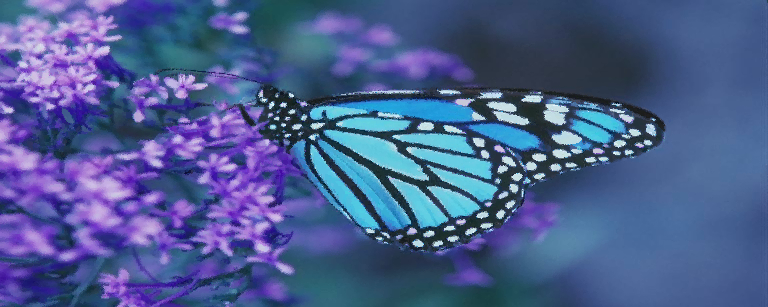

In [17]:
if __name__ == "__main__":
    #img = np.array(Image.open("./cup_a.jpg"))
    #ref = np.array(Image.open("./cup_b.jpg"))
    p_size = 3
    itr = 5
    start = time.time()
    f = NNS(resized_image, org_image, p_size, itr)
    end = time.time()
    print(end - start)
    reconstruction(f, resized_image, org_image)

[12  4]


In [13]:
!pip3 install tqdm

     |████████████████████████████████| 75 kB 1.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
